# **Análise Evasão Clientes - Part 2**

### **Importanto o conjunto de dados**

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [3]:
df = pd.read_csv('df_churn.csv')

In [4]:
df.head()

,customerid,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,charges_monthly,charges_total,charges_daily,churn_bin
0,0002-ORFBO,No,Female,No,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667,0
1,0003-MKNFE,No,Male,No,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667,0
2,0004-TLHLJ,Yes,Male,No,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333,1
3,0011-IGKFF,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667,1
4,0013-EXCHZ,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667,1


### **Limpando os dados**

In [5]:
df_churn = df.drop(['customerid','churn'], axis=1)
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   seniorcitizen     7032 non-null   object 
 2   partner           7032 non-null   object 
 3   dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   phoneservice      7032 non-null   object 
 6   multiplelines     7032 non-null   object 
 7   internetservice   7032 non-null   object 
 8   onlinesecurity    7032 non-null   object 
 9   onlinebackup      7032 non-null   object 
 10  deviceprotection  7032 non-null   object 
 11  techsupport       7032 non-null   object 
 12  streamingtv       7032 non-null   object 
 13  streamingmovies   7032 non-null   object 
 14  contract          7032 non-null   object 
 15  paperlessbilling  7032 non-null   object 
 16  paymentmethod     7032 non-null   object 


### **Separar Variáveis Categóricas e Numéricas**

In [8]:
def detec_auto(data: pd.DataFrame):
    bool_like = []
    for col in data.columns:
        if data[col].dtype == 'object':
            vals = data[col].dropna().astype(str).str.lower().unique()
            if set(vals).issubset({'yes','no','y','n','true','false','sim','não','nao'}):
                bool_like.append(col)


    num_cols_auto = data.select_dtypes(include=['number']).columns.tolist()
    cat_cols_auto = list(set(data.columns) - set(num_cols_auto))

    for col in bool_like:
        if col not in cat_cols_auto:
            cat_cols_auto.append(col)
        if col in num_cols_auto:
            num_cols_auto.remove(col)

    #checagem se todas as colunas foram tratadas
    print(f'Quantidade de Variaveis: {len(data.columns)}\n')
    print(f'Quantidade de Variaveis Númericas identificadas: {len(num_cols_auto)}')
    print('\n'.join([f' {i}' for i in num_cols_auto]))
    print('-'*85)
    print(f'Quantidade de Variaveis Categoricas identificadas: {len(cat_cols_auto)}')
    print('\n'.join([f' {i}' for i in cat_cols_auto]))

    return num_cols_auto, cat_cols_auto

In [9]:
numeric_cols, categorical_cols = detec_auto(df_churn)

Quantidade de Variaveis: 21

Quantidade de Variaveis Númericas identificadas: 5
 tenure
 charges_monthly
 charges_total
 charges_daily
 churn_bin
-------------------------------------------------------------------------------------
Quantidade de Variaveis Categoricas identificadas: 16
 internetservice
 paperlessbilling
 seniorcitizen
 multiplelines
 streamingtv
 phoneservice
 streamingmovies
 deviceprotection
 onlinesecurity
 partner
 contract
 onlinebackup
 dependents
 paymentmethod
 gender
 techsupport


### **Encoding Variáveis Categóricas**

In [10]:
df_encoded = pd.get_dummies(df_churn, columns=categorical_cols, dtype=int, drop_first=True)
df_encoded.head()

,tenure,charges_monthly,charges_total,charges_daily,churn_bin,internetservice_Fiber optic,internetservice_No,paperlessbilling_Yes,seniorcitizen_Yes,multiplelines_No phone service,...,contract_Two year,onlinebackup_No internet service,onlinebackup_Yes,dependents_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,gender_Male,techsupport_No internet service,techsupport_Yes
0,9,65.6,593.30,2.186667,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,1
1,9,59.9,542.40,1.996667,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,4,73.9,280.85,2.463333,1,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,13,98.0,1237.85,3.266667,1,1,0,1,1,0,...,0,0,1,0,0,1,0,1,0,0
4,3,83.9,267.40,2.796667,1,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1


### **Check balanceamento da Variável Alvo**

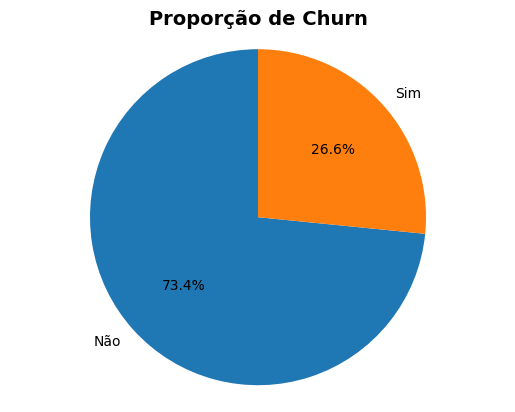

In [11]:
labels = ['Não', 'Sim']
sizes = df_encoded['churn_bin'].value_counts().sort_index()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proporção de Churn', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

### **Separação de Dados**

In [12]:
X = df_encoded.drop(columns=['churn_bin'])
y = df_encoded['churn_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Tamanho do conjunto de Treino:\nX_train: {X_train.shape}\ny_train: {y_train.shape}\n')
print(f'Tamanho do conjunto de Teste:\nX_test: {X_test.shape}\ny_test: {y_test.shape}')

Tamanho do conjunto de Treino:
X_train: (5625, 31)
y_train: (5625,)

Tamanho do conjunto de Teste:
X_test: (1407, 31)
y_test: (1407,)


### **Balanceamento de Classes**

Em analise anterior observamos que os dados estavam muito desbalanceado, sendo 73,4% dos dados de clientes que permanece na empresa e 26,6% de clientes que sairam da empresa.

Foi utilizado do SMOTE, que gera amostras sintéticas dos dados para o balanceamento das classes.

<mark> **Atenção**: O balanceamento foi feito apenas no conjunto de treino!</mark>

In [13]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print('Antes do balanceamento:', y_train.value_counts(), '\n')
print('Depois do balanceamento:', y_train_bal.value_counts())

Antes do balanceamento: churn_bin
0    4130
1    1495
Name: count, dtype: int64 

Depois do balanceamento: churn_bin
0    4130
1    4130
Name: count, dtype: int64


## **Modelagem Preditiva**

### **Base Line**

In [ ]:
def treinar_avaliar_baseline(models, X_train, y_train, X_test, y_test):
    resultados = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc  = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)

        print(f'Modelo: {name}\n')
        print(f'Recall:   {rec:.4f}')
        print(f'F1-score: {f1:.4f}')
        print(f'Precisão: {prec:.4f}')
        print(f'Acurácia: {acc:.4f}')
        print('-'*50)

        resultados.append({
            'model': name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })

    return resultados

In [24]:
# Regressão Logística
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])

# KNN
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Random Forest
rf = RandomForestClassifier(random_state=42)

# GradientBosting
gbc = GradientBoostingClassifier(random_state=42)

models = {'LogisticRegression': pipe_lr, 'KNeighborsClassifier': pipe_knn, 'RandomForest': rf, 'GradientBosting': gbc }

In [25]:
metric_baseline = treinar_avaliar_baseline(models, X_train_bal, y_train_bal, X_test, y_test)

Modelo: LogisticRegression

Recall:   0.6524
F1-score: 0.6055
Precisão: 0.5648
Acurácia: 0.7740
--------------------------------------------------
Modelo: KNeighborsClassifier

Recall:   0.6444
F1-score: 0.5618
Precisão: 0.4979
Acurácia: 0.7328
--------------------------------------------------
Modelo: RandomForest

Recall:   0.6070
F1-score: 0.5851
Precisão: 0.5647
Acurácia: 0.7711
--------------------------------------------------
Modelo: GradientBosting

Recall:   0.7059
F1-score: 0.6212
Precisão: 0.5546
Acurácia: 0.7711
--------------------------------------------------


### **Validação Cruzada**

In [26]:
def treinar_avaliar_modelos_cv(models, n_splits, scoring, X_train, y_train, X_test, y_test):
    resultados = []

    for name, model in models.items():
        cv = StratifiedKFold(n_splits, shuffle=True, random_state=42)
        cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)

        acc = cv_results['test_accuracy'].mean()
        prec = cv_results['test_precision'].mean()
        rec = cv_results['test_recall'].mean()
        f1 = cv_results['test_f1'].mean()

        print(f'Modelo: {name}\n')
        print(f'Recall médio: {rec:.4f}')
        print(f'F1-score médio: {f1:.4f}')
        print(f'Precisão média: {prec:.4f}')
        print(f'Acurácia média: {acc:.4f}')
        print('-'*60)

        resultados.append({
            'model': name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })

    return resultados

In [27]:
new_models = {
    'LogisticRegression': ImbPipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'KNeighborsClassifier': ImbPipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('smote', SMOTE(random_state=42)),
        ('clf', KNeighborsClassifier())
    ]),
    'RandomForest': ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'GradientBoosting': ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', GradientBoostingClassifier(random_state=42))
    ])
}

In [28]:
scoring = {
    'recall': 'recall',
    'f1': 'f1',
    'precision': 'precision',
    'accuracy': 'accuracy'
}

In [29]:
metric_cv = treinar_avaliar_modelos_cv(new_models, 5, scoring, X_train, y_train, X_test, y_test)

Modelo: LogisticRegression

Recall médio: 0.7960
F1-score médio: 0.6329
Precisão média: 0.5254
Acurácia média: 0.7547
------------------------------------------------------------
Modelo: KNeighborsClassifier

Recall médio: 0.7130
F1-score médio: 0.5457
Precisão média: 0.4420
Acurácia média: 0.6843
------------------------------------------------------------
Modelo: RandomForest

Recall médio: 0.5819
F1-score médio: 0.5785
Precisão média: 0.5757
Acurácia média: 0.7746
------------------------------------------------------------
Modelo: GradientBoosting

Recall médio: 0.6776
F1-score médio: 0.6125
Precisão média: 0.5592
Acurácia média: 0.7721
------------------------------------------------------------


### **Melhores Parametros com GridSearchCV**

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
param_grid_lr = {
    'clf__C': [0.001, 0.01, 0.1],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__max_iter': [100, 200, 300]
    }

pipe_lr = new_models['LogisticRegression']

model_grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid_lr,
    scoring='recall',
    cv=cv
    )

model_grid_lr.fit(X_train, y_train)
y_pred_lr = model_grid_lr.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred_lr)
prec = precision_score(y_test, y_pred_lr)
rec = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

metric_grid_lr = {
    'model': 'LogisticRegression',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}

print(f'Modelo: LogisticRegression \n'
      f'Melhores parâmetros: {model_grid_lr.best_params_}\n'
      f'Recall:   {rec:.4f}\n'
      f'F1-Score: {f1:.4f}\n'
      f'Precisão: {prec:.4f}\n'
      f'Acurácia: {acc:.4f}'
      )

Modelo: LogisticRegression 
Melhores parâmetros: {'clf__C': 0.1, 'clf__max_iter': 100, 'clf__solver': 'lbfgs'}
Recall:   0.7995
F1-Score: 0.6321
Precisão: 0.5227
Acurácia: 0.7527


In [34]:
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9, 11, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
    }

pipe_knn = new_models['KNeighborsClassifier']

model_grid_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring='recall',
    cv=cv
    )

model_grid_knn.fit(X_train, y_train)
y_pred_knn = model_grid_knn.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred_knn)
prec = precision_score(y_test, y_pred_knn)
rec = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

metric_grid_knn = {
    'model': 'KNeighborsClassifier',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}

print(f'Modelo: KNeighborsClassifier \n'
      f'Melhores parâmetros: {model_grid_knn.best_params_}\n'
      f'Recall:   {rec:.4f}\n'
      f'F1-Score: {f1:.4f}\n'
      f'Precisão: {prec:.4f}\n'
      f'Acurácia: {acc:.4f}'
      )

Modelo: KNeighborsClassifier 
Melhores parâmetros: {'clf__n_neighbors': 15, 'clf__p': 2, 'clf__weights': 'uniform'}
Recall:   0.8102
F1-Score: 0.5844
Precisão: 0.4570
Acurácia: 0.6937


In [35]:
param_grid_rf = {
    'clf__max_depth': [2, 3, 5, 7, 10],
    'clf__min_samples_leaf': [3, 4, 5],
    'clf__min_samples_split': [2, 3, 4],
    'clf__n_estimators': [100, 150, 200, 300]
    }

pipe_rf = new_models['RandomForest']

model_grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring='recall',
    cv=cv
    )

model_grid_rf.fit(X_train, y_train)
y_pred_rf = model_grid_rf.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf)
rec = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

metric_grid_rf = {
    'model': 'RandomForest',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}

print(f'Modelo: RandomForest \n'
      f'Melhores parâmetros: {model_grid_rf.best_params_}\n'
      f'Recall:   {rec:.4f}\n'
      f'F1-Score: {f1:.4f}\n'
      f'Precisão: {prec:.4f}\n'
      f'Acurácia: {acc:.4f}'
      )

Modelo: RandomForest 
Melhores parâmetros: {'clf__max_depth': 2, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Recall:   0.7861
F1-Score: 0.6062
Precisão: 0.4933
Acurácia: 0.7285


In [36]:
param_grid_gbc = {
    'clf__max_depth': [2, 3, 5, 7, 10],
    'clf__min_samples_leaf': [3, 4, 5],
    'clf__min_samples_split': [2, 3, 4],
    'clf__n_estimators': [100, 150, 200, 300]
    }

pipe_gbc = new_models['GradientBoosting']

model_grid_gbc = GridSearchCV(
    estimator=pipe_gbc,
    param_grid=param_grid_gbc,
    scoring='recall',
    cv=cv
    )

model_grid_gbc.fit(X_train, y_train)
y_pred_gbc = model_grid_gbc.best_estimator_.predict(X_test)

acc = accuracy_score(y_test, y_pred_gbc)
prec = precision_score(y_test, y_pred_gbc)
rec = recall_score(y_test, y_pred_gbc)
f1 = f1_score(y_test, y_pred_gbc)

metric_grid_gbc = {
    'model': 'GradientBoosting',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1
}

print(f'Modelo: RandomForest \n'
      f'Melhores parâmetros: {model_grid_gbc.best_params_}\n'
      f'Recall:   {rec:.4f}\n'
      f'F1-Score: {f1:.4f}\n'
      f'Precisão: {prec:.4f}\n'
      f'Acurácia: {acc:.4f}'
      )

Modelo: RandomForest 
Melhores parâmetros: {'clf__max_depth': 2, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Recall:   0.7326
F1-Score: 0.6220
Precisão: 0.5404
Acurácia: 0.7633


### **Análise das Métricas e Definição do modelo**

In [37]:
def to_df(obj, stage):
    if isinstance(obj, list):
        df = pd.DataFrame(obj)
    else:  
        df = pd.DataFrame([obj])
    df["stage"] = stage
    return df

In [44]:
dfs = []
dfs.append(to_df(metric_baseline, 'Baseline'))
dfs.append(to_df(metric_cv,       'CV (5-fold)'))
dfs.append(to_df(metric_grid_lr,  'Grid LR'))
dfs.append(to_df(metric_grid_knn, 'Grid KNN'))
dfs.append(to_df(metric_grid_rf,  'Grid RF'))
dfs.append(to_df(metric_grid_gbc, 'Grid GB'))

metrics_df = pd.concat(dfs, ignore_index=True)

cols = ['model', 'stage', 'accuracy', 'precision', 'recall', 'f1']
metrics_df = metrics_df[cols]

In [45]:
metrics_df['model'] = metrics_df['model'].replace({'GradientBosting':'GradientBoosting'})
metrics_df['stage'] = metrics_df['stage'].replace({
    'Grid LR': 'GridSearch',
    'Grid KNN': 'GridSearch',
    'Grid RF': 'GridSearch',
    'Grid GB': 'GridSearch'
})

metrics_df = metrics_df.dropna(subset=['recall','precision','accuracy','f1'], how='all')
stage_order = ["Baseline", "CV (5-fold)", "GridSearch"]
metrics_df['stage'] = pd.Categorical(metrics_df['stage'], categories=stage_order, ordered=True)

metrics_df.head()

,model,stage,accuracy,precision,recall,f1
0,LogisticRegression,Baseline,0.773987,0.564815,0.652406,0.605459
1,KNeighborsClassifier,Baseline,0.732765,0.497934,0.644385,0.561772
2,RandomForest,Baseline,0.771144,0.564677,0.606952,0.585052
3,GradientBoosting,Baseline,0.771144,0.554622,0.705882,0.621176
4,LogisticRegression,CV (5-fold),0.754667,0.525418,0.795987,0.632942


In [77]:
def plot_metric(metric_name, ylabel=None, title=None):
    pivot = (metrics_df
             .pivot_table(index="model", columns="stage", values=metric_name, aggfunc="mean", observed=False)
             .reindex(columns=stage_order))
    models = pivot.index.to_list()
    stages = pivot.columns.to_list()

    x = np.arange(len(models))
    n = len(stages)
    width = 0.90 / max(n, 1) 

    fig, ax = plt.subplots(figsize=(10, 5))
    for i, s in enumerate(stages):
        vals = pivot[s].values.astype(float)
        bars = ax.bar(x + (i - (n-1)/2)*width, vals, width, label=s)

        for b, v in zip(bars, vals):
            if np.isnan(v) or v <= 0:
                continue
            ax.annotate(f"{v*100:.2f}%",
                        (b.get_x() + b.get_width()/2, v),
                        ha="center", va="bottom", fontsize=8, fontweight='bold')

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=0)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_ylim(0, 1)
    ax.legend(title="Fase", bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

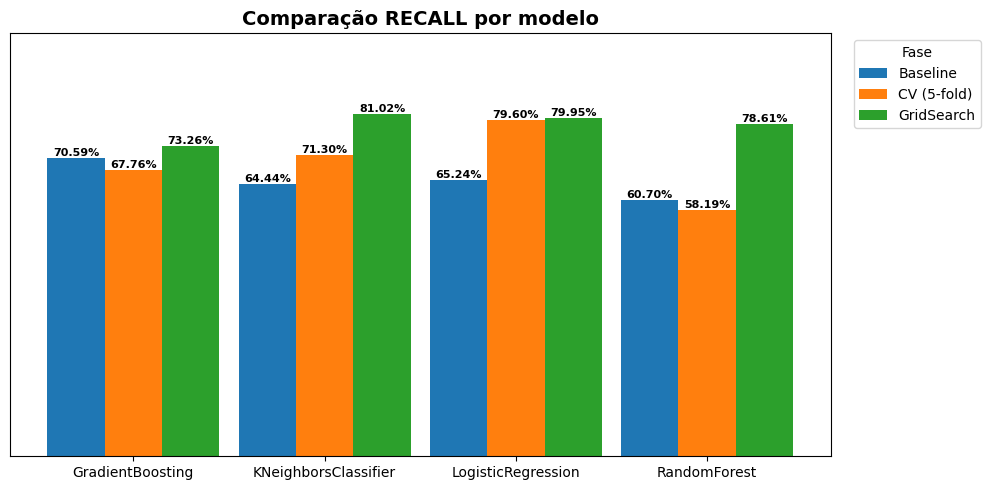

In [78]:
plot_metric("recall", title="Comparação RECALL por modelo")

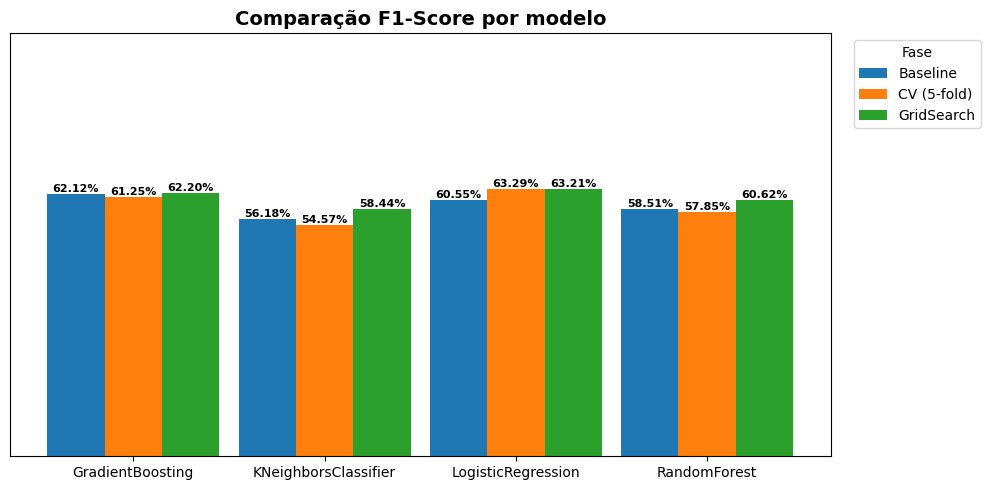

In [79]:
plot_metric("f1", title="Comparação F1-Score por modelo")

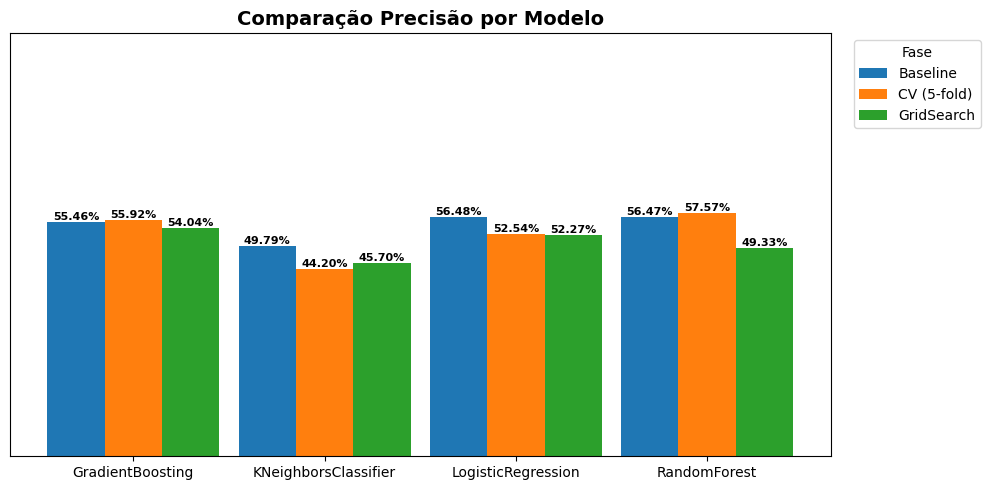

In [80]:
plot_metric(metric_name='precision', title='Comparação Precisão por Modelo')

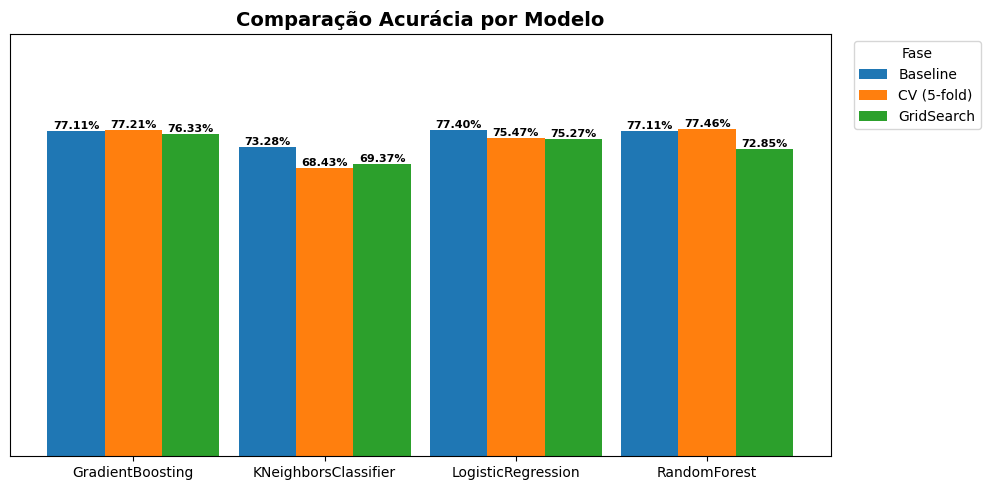

In [82]:
plot_metric(metric_name='accuracy', title='Comparação Acurácia por Modelo')

In [86]:
best_models = {}
best_models['LogisticRegression'] = model_grid_lr.best_estimator_
best_models['KNN']                = model_grid_knn.best_estimator_
best_models['RandomForest']       = model_grid_rf.best_estimator_
best_models['GradientBoosting']   = model_grid_gbc.best_estimator_

In [99]:
def custo_ponderado(cm, custo_fn=5, custo_fp=1):
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    custo = fn*custo_fn + fp*custo_fp
    positivos_reais = fn + tp
    negativos_reais = tn + fp
    custo_max = positivos_reais*custo_fn + negativos_reais*custo_fp
    score = (1 -(custo / custo_max) )*100       
    return custo, score

def plotar_matrizes(best_models, X_test, y_test, labels=('Não','Sim')):
    for nome, modelo in best_models.items():
        y_pred = modelo.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        custo, score = custo_ponderado(cm, custo_fn=5, custo_fp=1)

        ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues')
        plt.title(f'Matriz de Confusão - {nome} \n Custo = {custo:.0f} | Score = {score:.2f}%')
        plt.show()



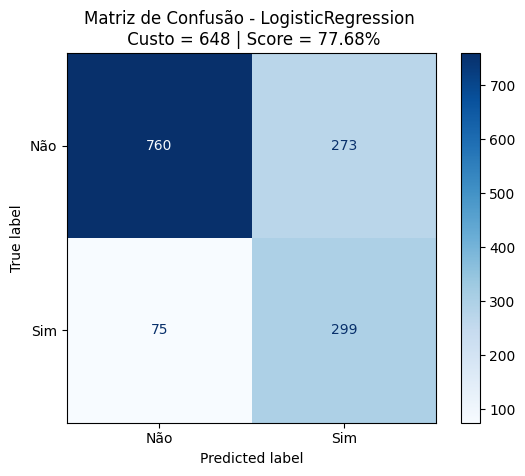

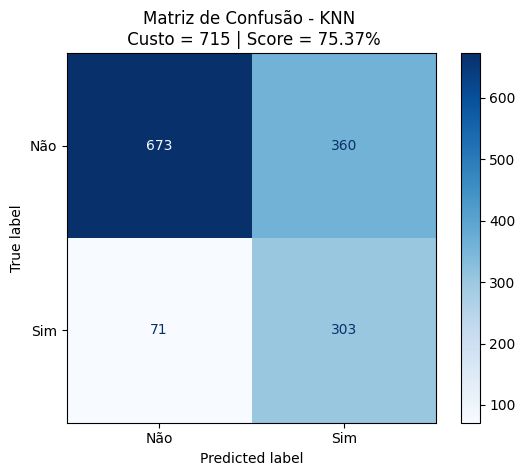

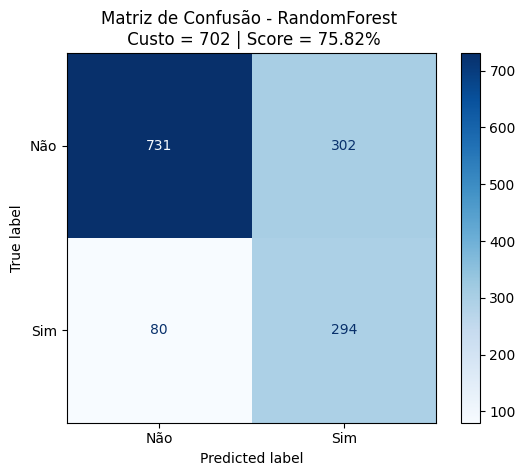

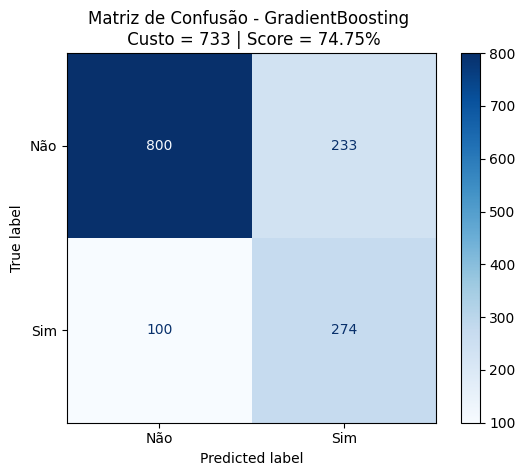

In [100]:
plotar_matrizes(best_models, X_test, y_test)

### **Exportação do modelo**

In [102]:
try:
  with open('model_LogisticRegression.pkl', 'wb') as file:
    pickle.dump(model_grid_lr.best_estimator_, file)
  print('Modelo salvo com sucesso!')

except Exception as e:
  print('Erro:', str(e))

Modelo salvo com sucesso!


### **Análise de Importância das Variáveis**

In [156]:
coefs = model_grid_lr.best_estimator_.named_steps['clf'].coef_[0]

feat_imp_lr = pd.DataFrame({
    'feature': X.columns,
    'coef': coefs,
    'importance': np.abs(coefs)
})

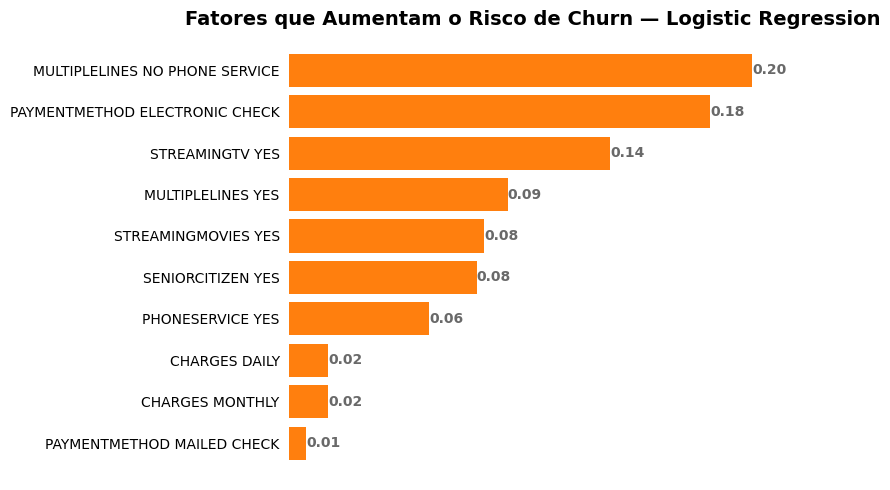

In [ ]:
feat_imp_lr['feature_fmt'] = feat_imp_lr['feature'].str.replace('_', ' ').str.upper()
feat_imp_lr_pos = feat_imp_lr[feat_imp_lr['coef'] > 0].sort_values('coef', ascending=True).head(10)
feat_imp_lr_neg = feat_imp_lr[feat_imp_lr['coef'] < 0].sort_values('coef', ascending=False).head(10)

plt.figure(figsize=(8,5))
bars = plt.barh(feat_imp_lr_pos['feature_fmt'][:10], feat_imp_lr_pos['coef'], color='#ff7f0e')
for bar, value in zip(bars, feat_imp_lr_pos['coef']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f"{value:.2f}", 
             va='center', ha='left', color='dimgray', fontsize=10, fontweight='bold')
plt.title('Fatores que Aumentam o Risco de Churn — Logistic Regression', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.xticks([])
plt.gca().tick_params(left=False)
plt.box(False)
plt.tight_layout()
plt.show()

# Relatório Final

Foram testados e avaliados quatro modelos: LogisticRegression, KNeighborsClassifier, RandomForest e GradientBoosting, em três etapas de aprimoramento. A primeira etapa utilizou os modelos sem ajustes de parâmetros; a segunda aplicou validação cruzada, dividindo os dados de treino em 5 subconjuntos; e a terceira, e última, definiu os melhores parâmetros para cada modelo, também com validação cruzada em 5 subconjuntos.

Não foram identificados sinais de que algum modelo tenha aprendido demais apenas os dados de treinamento (overfitting) ou que tenha apresentado desempenho muito abaixo do esperado (underfitting). O uso de pipelines integrando o SMOTE e o StandardScaler durante a validação cruzada e o ajuste de parâmetros ajudou a reduzir o risco de vazamento de dados, garantindo que a normalização e o balanceamento fossem aplicados somente aos dados de treino em cada subdivisão da validação. Foi observado que o KNeighborsClassifier apresentou a maior sensibilidade (recall = 81,02%) na etapa de ajuste de parâmetros; porém, na avaliação geral, seu desempenho foi inferior aos demais, com menor consistência na identificação de clientes em risco.

A escolha final recaiu sobre o modelo de Regressão Logística (LogisticRegression), considerando os resultados da matriz de confusão e a premissa de que a perda de um cliente representa um impacto significativamente maior para a empresa do que o esforço para retê-lo. Nos dados de teste (20% do total), o modelo identificou corretamente 299 clientes que cancelaram e 760 que permaneceram ativos. Por outro lado, classificou de forma equivocada 273 clientes como canceladores, quando na realidade permaneceriam, e deixou de identificar 75 clientes que efetivamente cancelaram.

Para quantificar esse impacto, foi atribuído um peso cinco vezes maior para cada cliente perdido em comparação ao esforço de retenção mal direcionado. Assim, o custo calculado foi de 648 pontos (75 x 5 + 273 x 1), representando a soma ponderada desses dois tipos de erro. Comparando esse custo com o pior cenário possível para o conjunto de dados, obtém-se um índice de custo evitado de 77,68%, o que significa que, com o auxílio do modelo, foi possível evitar mais de três quartos do impacto potencial das perdas por cancelamento.

Além do desempenho obtido, a análise das variáveis mais influentes na previsão dos clientes sair da empresa evidencia quais características mais contribuem para aumentar a probabilidade de cancelamento, segundo o modelo.

Entre os principais fatores de risco identificados destacam-se: ausência de telefone fixo, pagamento por débito eletrônico, uso de serviços de TV ou filmes por streaming e posse de múltiplas linhas. Também foi observado que clientes idosos apresentam maior probabilidade de cancelamento. Em alguns casos, a forma de pagamento, como cheque enviado pelo correio, embora menos frequente, também está associada a maior risco.

Essas informações permitem à empresa direcionar de forma mais estratégica as ações de retenção, priorizando clientes com esse perfil para minimizar perdas, concentrando esforços onde o impacto potencial sobre a redução do churn é mais significativo.